In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george

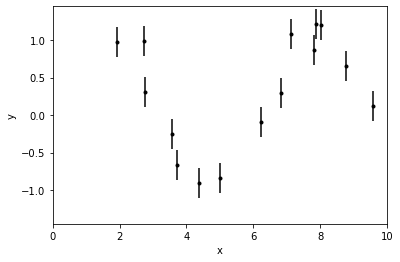

In [3]:
import numpy as np
import matplotlib.pyplot as pl

np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

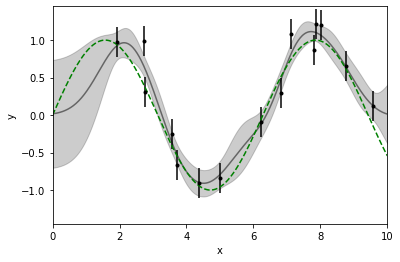

In [343]:
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

## Fitting the GP

In [344]:
M = kernel.get_value(atleast_2d(x).T) 
def mvp(x):
    return M.dot(x)

In [345]:
Mg = kernel.get_gradient(atleast_2d(x).T)
def gmvp(x):
    return np.einsum('ijk,jk->ik', Mg, x)

In [370]:
import numpy as np

def eigen_max(operator, shape, num_iters=10):
    """
    Compute maximum eigenvalue of the operator by the power method.
    shape: input shape for the probe operator, usually: [batch_size, d]
    num_iters: number of power method iterations to compute the maximum
        eigenval, at each call to the model, the eigenvector is cached.
    """
    def _l2normalize(v, eps=1e-12):
        return v / np.linalg.norm(v)

    u = np.ones(shape)    
    for i in range(num_iters):
        u = _l2normalize(operator(u))
    
    result = u.T.dot(operator(u))
    
    return result

def ChebyshevCoefficients(operator, a, b, n):
    """
    Returns Chebyshev coefficients up to order `n` for the function `operator`
    defined in the interval [a, b]

    WARNING: Returns 2x the coefficient c0
    TODO: Figure out how to divide c0 by 2 :-/
    """
    bma = 0.5 * (b - a)
    bpa = 0.5 * (b + a)

    xk = np.cos(math.pi * (np.arange(n+1) + 0.5)/(n + 1)) * bma + bpa
    f = operator(xk)

    i = np.arange(n+1)
    xk, _ = np.meshgrid(i, i)
    fac = 2.0 / (n+1)
    c = fac * (f * np.cos(xk.T * (math.pi * (xk + 0.5) / (n+1)))).sum(axis=1)
    return c


def StochasticChebyshevTrace(operator, shape, coeffs):
    """
    Computes the trace of the Chebyshev expansion of the function defined by
    `coeffs` and applied to `operator`, using the Hutchinson estimator

    operator: input operator
    shape: shape of input random vector to use, typically [batch_size, d]
    coeffs: Chebyshev coefficients of the function to evaluate
    n_probe: number of rademacher samples

    WARNING: Will divide coeffs[0] by two
    """
    # Sample a rademacher tensor with desired size
    v = 1 - 2*np.random.binomial(1,0.5,shape)
    
    # Initialize the iteration
    w0, w1 = v, operator(v)
    
    s = 0.5*coeffs[0]*w0 + coeffs[1]*w1

    for i in range(2, coeffs.shape[0]):
        wi = 2.*operator(w1) - w0
        s = s + coeffs[i]*wi
        w0=w1*1.0
        w1=wi*1.0
    
    return v.T.dot(s)


def StochasticGradChebyshevTrace(operator, grad_operator, shape, coeffs):
    """
    Computes the trace of the Chebyshev expansion of the function defined by
    `coeffs` and applied to `operator`, using the Hutchinson estimator

    operator: input operator
    shape: shape of input random vector to use, typically [batch_size, d]
    coeffs: Chebyshev coefficients of the function to evaluate
    n_probe: number of rademacher samples

    WARNING: Will divide coeffs[0] by two
    """
    # Sample a rademacher tensor with desired size
    v = 1 - 2*np.random.binomial(1,0.5,shape)
    
    # Initialize the iteration
    w0, w1 = v, operator(v)
    gw0 = 0*grad_operator(v)
    gw1 = grad_operator(v)
    
    s  = 0.5*coeffs[0]*w0  + coeffs[1]*w1
    gs = 0.5*coeffs[0]*gw0 + coeffs[1]*gw1

    for i in range(2, coeffs.shape[0]):
        wi = 2.*operator(w1) - w0
        s = s + coeffs[i]*wi
        w0=w1*1.0
        w1=wi*1.0
        
        gwi = 2.*grad_operator(w1) + 2*operator(gw1) - gw0
        gs = gs + coeffs[i]*gwi
        gw0=gw1*1.0
        gw1=gwi*1.0
        
    return v.T.dot(s), v.T.dot(gs)


def chebyshev_grad_logdet(operator, grad_operator, shape, deg=20, num_iters=10, g=1.1, eps=1e-6, m=100):
    """
    Computes the spectral sum tr(f(A)), where A is the operator,
    f is the func, [a, b] is the range of eigenvalues of A.

    shape: Shape of input vectors to the operator, typically [batch, d]
    deg: Degree of the Chebyshev approximation
    m: Number of random vectors to probe the trace

    This corresponds to Algorithm 1 in Han et al. 2017
    """
    # Find the largest eigenvalue amongst the batch
    lmax = eigen_max(operator, shape, num_iters)
    a, b = eps, g*lmax

    # Rescales the operator
    def scaled_op(x):
        return operator(x) # / (a+b)
    
    def scaled_gop(x):
        return grad_operator(x) #/ (a+b)
    
#     a1 = a / (a + b)
#     b1 = b / (a + b)
    a1 =a
    b1 =b
    
    # Compute the chebyshev coefficients of the operator
    c = ChebyshevCoefficients(np.log, a1, b1, deg)

    # Rescales the operator
    def scaled_op1(x):
        return 2. * scaled_op(x) / (b1 - a1) - (b1 + a1)/(b1 - a1) * x
    
    def scaled_gop1(x):
        return 2. * scaled_gop(x) / (b1 - a1)
    
    res = []
    resg = []
    
    for i in range(m):
        Gamma, grad_gamma = StochasticGradChebyshevTrace(scaled_op1, scaled_gop1, shape=shape, coeffs=c)
        res.append( Gamma ) 
        resg.append(grad_gamma)
        
    return np.concatenate(res), np.concatenate(resg)

In [371]:
log_det, glog_det = chebyshev_grad_logdet(mvp, gmvp, shape=(15,1), m=1000, deg=100, g=1.01, num_iters=20)

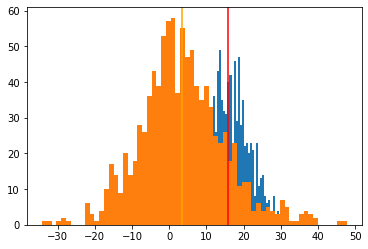

In [372]:
hist(glog_det[:,0],64);
axvline(mean(glog_det[:,0]),color='red');
hist(glog_det[:,1],64);
axvline(mean(glog_det[:,1]), color='orange');

In [374]:
print(mean(glog_det[:,1]))

3.552293431190626


In [375]:
gp.grad_log_likelihood(0*y)

array([-4.61741638,  2.72658792])

In [376]:
Kg = kernel.get_gradient(atleast_2d(x).T)
A = kernel.get_value(atleast_2d(x).T)

In [377]:
lg = -0.5*inv(A).dot(Kg)

In [379]:
trace(lg[:,:,1])

14.559771013646811

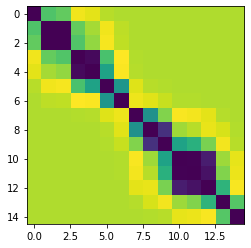

In [330]:
imshow(Kg[:,:,0] - A)

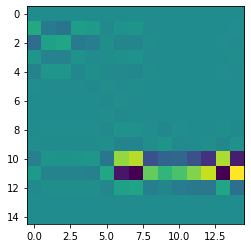

In [331]:
imshow(lg[:,:,0])

In [245]:
self = gp

alpha = self._compute_alpha(y, False)
    
K_inv = self.solver.get_inverse()
A = - K_inv

# Compute each component of the gradient.
grad = np.empty(len(self))
n = 0

Kg = self.kernel.get_gradient(self._x)
grad[:] = 0.5 * np.einsum("ijk,ij", Kg, A)


In [246]:
grad

array([-4.61741638,  2.72658792])

In [189]:
log_det = chebyshev_logdet(mvp, shape=(15,1), m=2000, deg=30, g=1.01, num_iters=20)

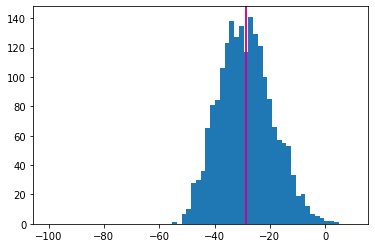

In [190]:
hist(log_det,64,range=[-100,10]);
axvline(np.linalg.slogdet(M)[1], color='red');
axvline(np.mean(log_det), color='m')

In [198]:
a0, b0 = 0.001, max(eigvals(M))*1.01

B = M / (a0 + b0)
a = a0 / (a0 + b0)
b = b0 / (a0 + b0)

In [199]:
eigvals(B)

array([0.98962148, 0.82366412, 0.50987752, 0.47507951, 0.32208611,
       0.27238728, 0.14734165, 0.12672917, 0.07970081, 0.04271024,
       0.01021362, 0.00545581, 0.00531122, 0.00484472, 0.00482363])

In [200]:
# Now, we define the scaled matrix C with eigenvalues covering [-1,1]
C = 2 / (b - a) * B - (b+a)/(b-a)*eye(15)

In [201]:
C2 = diag(eigvals(C))
eigvals(C)

array([ 0.98018846,  0.64795326,  0.01977412, -0.04988911, -0.35617135,
       -0.45566499, -0.70599771, -0.74726247, -0.84141001, -0.9154626 ,
       -0.98051858, -0.99004339, -0.99033285, -0.99126676, -0.99130898])

In [202]:
coeffs = ChebyshevCoefficients(log, a, b, 100)
coeffs[0] /=2

In [203]:
from numpy.polynomial import Chebyshev
poly = Chebyshev(coeffs[0:30], domain=[-1,1])

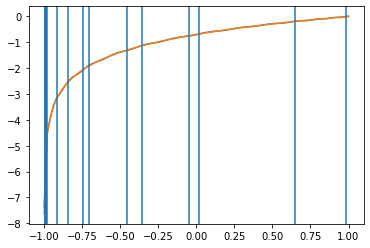

In [204]:
z = linspace(-1.,1,100)
plot(z, poly(z))
plot(z, log( (b -a)/2 *z + (b+a)/2))
for i in range(15):
    axvline(eigvals(C2)[i])

In [205]:
def chebyshev_poly(c):
    T0 = eye(15)
    T1 = C
    r = c[0]*T0 + c[1]*T1
    for i in range(2, len(c)):
        T = 2*C.dot(T1) - T0
        T0=T1
        T1=T
        r += c[i]*T
    return r

In [206]:
ts0 = []
for i in range(3,100):
    D = chebyshev_poly(coeffs[:i])
    ts0.append(trace(D))

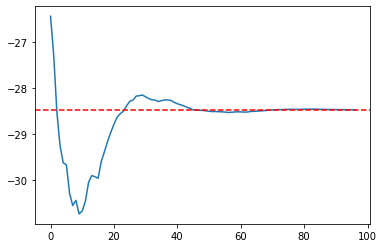

In [207]:
plot(ts0+ 15*log(a0+b0))
axhline(np.linalg.slogdet(M)[1],ls='--',color='r')

In [43]:
1 - 2*np.random.binomial(1,0.5,10)

array([-1, -1, -1, -1, -1, -1,  1, -1,  1,  1])

In [39]:
ChebyshevCoefficients(np.log, 0.001,1, 20)

array([-2.64159989,  1.87090315, -0.87458158,  0.54471861, -0.38131968,
        0.28438921, -0.22059722,  0.17566025, -0.14243652,  0.11695758,
       -0.09684095,  0.0805684 , -0.06712511,  0.05580512, -0.04610012,
        0.03763245, -0.03011309,  0.02331417, -0.01705033,  0.01116556,
       -0.00552354])

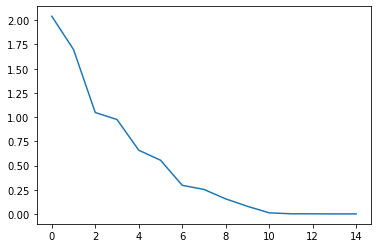

In [115]:
plot(eigvals(M))

In [116]:
eigvals(M)

array([2.04184124e+00, 1.69775194e+00, 1.04715948e+00, 9.75010680e-01,
       6.57800339e-01, 5.54756790e-01, 2.95492241e-01, 2.52755156e-01,
       1.55248451e-01, 7.85536812e-02, 1.11765143e-02, 1.31186462e-03,
       1.01207172e-03, 4.48402345e-05, 1.10982444e-06])

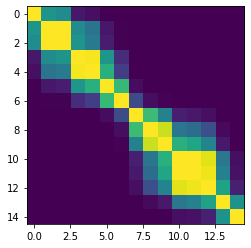

In [10]:
imshow(kernel.get_value(atleast_2d(x).T))

In [208]:
kernel.get_gradient(atleast_2d(x).T).shape

(15, 15, 2)

In [20]:
alpha = gp._compute_alpha(y, False)

In [215]:
gmvp(np.ones((15,1))).shape

(15, 2)

In [22]:
K_inv = gp.solver.get_inverse()

In [27]:
A = np.einsum("i,j", alpha, alpha) - K_inv

In [29]:
A.shape

(15, 15)

In [31]:
np.einsum("i,j", alpha, alpha).shape

(15, 15)

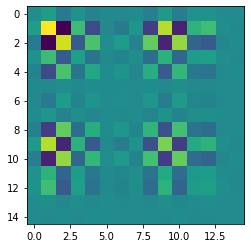

In [32]:
imshow(np.einsum("i,j", alpha, alpha))

In [ ]:
Kg = kernel.get_gradient(atleast_2d(x).T)

In [ ]:
# We only ask access to multiplications by the matrix


def GradVectorMultiplication(v):
    



In [8]:
len(kernel)

2

In [11]:
Kg = kernel.get_gradient(atleast_2d(x).T)

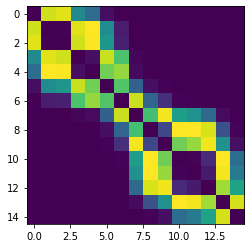

In [16]:
imshow(Kg[:,:,1])